In [ ]:
using LinearAlgebra
using Plots
d = 6
n = 10
A = Array{Matrix{Float64},1}(undef,n)
b = Array{Vector{Float64},1}(undef,n)
sumA = zeros(Float64,d,d)
sumb = zeros(Float64,d)
for i in 1:n
    mat = rand([0.0,3.0],d,d)
    tA = A[i] = mat'*mat/norm(mat)
    tb = b[i] = rand(d)
    sumA += tA
    sumb += tb
end
fo(x::Vector{T},A::Matrix{Float64},b::Vector{Float64}) where {T<:Real} = dot(x,A,x) + dot(b,x)
fos(x::Vector{T}) where {T<:Real} = fo(x,sumA,sumb)
fd(x::Vector{T},A::Matrix{Float64},b::Vector{Float64}) where {T<:Real} = 2*A*x + b
fds(x::Vector{T}) where {T<:Real} = fd(x,sumA,sumb)
xt, min = ((2*sumA)\(-sumb), fos((2*sumA)\(-sumb)))

In [ ]:

function gd(x_in,A,b,num,η::Float64=0.05)
    x = x_in
    val = Vector{Float64}(undef,num+1)
    val[1] = fo(x,A,b)
    for i in 1:num
        x = x - η*fd(x,A,b)
        val[i+1] = fo(x,A,b)
    end
    return x, val
end

function svrg(x_in,A,b,outer,inner,η::Float64=0.05)
    xk = x_in
    val = Vector{Float64}(undef,outer*inner+1)
    val[1] = fos(xk)
    for k in 1:outer
        # total gradient
        gds = fds(xk)/n
        xi = xk
        for i in 1:inner
            t = rand(1:n)
            xi = xi - η*(gds-fd(xk,A[t],b[t])+fd(xi,A[t],b[t]))
            val[(k-1)*inner+i+1] = fos(xi)
        end
        xk = xi
    end
    return xk, val
end

function sgd1(x_in,A,b,num,η::Float64=0.05)
    x = x_in
    val = Vector{Float64}(undef,num+1)
    val[1] = fos(x)
    for i in 1:num
        η_now = η*exp(-floor(i/30)/40)
        t = rand(1:n)
        x = x - η_now*fd(x,A[t],b[t])
        val[i+1] = fos(x)
    end
    return x, val
end

function smiso(x_in,A,b;num=1000,η=0.05)
    n = length(A)
    x = x_in
    z = Array{Vector{Float64},1}(undef,n)
    for i in 1:n
        z[i] = x*0.5*rand()
        end
    x = sum(z)/n  # initial x is important
    α = η
    val = Vector{Float64}(undef,num+1)
    val[1] = fos(x)
    eigs = eigvals(Symmetric(sum(A)))
    L = 2.1*maximum(eigs)*3.0
    μ = 1.9*minimum(eigs)
    for t in 1:num
        i = rand(1:n)
        αt = α*2n/(t+8L/μ)
        z_new = (1-αt)*z[i] + αt*(x-1/μ*fd(x,A[i],b[i]))
#         x = x + 1/n*(z_new-z[i])
        z[i] = z_new
        x = sum(z)/n
        val[t+1] = fos(x)
    end
    return x, val
end


In [ ]:
x0 = 0.5*ones(Float64,d)
eta = 35.0
_, val = smiso(x0,A,b,num=5000,η=eta)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
plot(log10.(val.-min),label="a0 = $eta",title="S-MISO: log10(residual)",size=[1000,600])

In [ ]:
val.-min

In [ ]:
using Plots
gr(legend=:right)
x0 = 0.5*ones(Float64,d)
eta = 0.05
nstep = 200*20+50
xt, val = sgd1(x0,A,b,nstep,eta)
plot(log10.(val.-min),label="SGD:$eta",size=[1000,600])
eta = 0.01
xt, val = sgd1(x0,A,b,nstep,eta)
plot!(log10.(val.-min),label="SGD:$eta")
eta = 0.0025
xt, val = sgd1(x0,A,b,nstep,eta)
plot!(log10.(val.-min),label="SGD:$eta")
eta = 0.001
xt, val = sgd1(x0,A,b,nstep,eta)
plot!(log10.(val.-min),label="SGD:$eta")
inner = 10
outer = 50
xt, val = svrg(x0,A,b,outer,inner,0.007*10)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
l = length(val)
range = map(x->(inner+n)*x/inner,1:l)
fig2 = plot!(range,log10.(val.-min),label="SVRG:0.07",xlabel="steps",ylabel="log10 residual")
savefig("sgd-vs-svrg.pdf")
fig2

In [ ]:
eta = 0.0025
xt, val = sgd1(x0,A,b,nstep,eta)
plot(log10.(val.-min),label="SGD:$eta")

inner = 10
outer = 50
xt, val = svrg(x0,A,b,outer,inner,0.007*10)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
l = length(val)
range = map(x->(inner+n)*x/inner,1:l)
plot!(range,log10.(val.-min),label="SVRG:0.07",xlabel="steps",ylabel="log10 residual")

xt, val = gd(x0,sumA,sumb,200,0.0109)
l = length(val)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
range = map(x->n*x,1:l)
fig3 = plot!(range,log10.(val.-min),label="GD:0.0109")
savefig(fig3,"sgd-vs-svrg2.pdf") 
fig3

In [ ]:
gr(legend=:right)
x0 = 0.5*ones(Float64,d)
eta = 0.05
nstep = 5000
xt, val = sgd1(x0,A,b,nstep,eta)
smi = plot(log10.(val.-min),label="SGD    eta = $eta",size=[1000,600])
eta = 35.0
_, val = smiso(x0,A,b,num=5000,η=eta)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
plot!(log10.(val.-min),label="S-MISO a0 = $eta",title="y: log10(residual)",size=[1000,600])
inner = 10
outer = 50
xt, val = svrg(x0,A,b,outer,inner,0.004*20)
for i in 1:length(val)
    if val[i]<min
        val[i] = val[i-1]
    end
end
l = length(val)
range = map(x->(inner+n)*x/inner,1:l)
plot!(range,log10.(val.-min),label="SVRG   o20 i10")
savefig(smi,"S-MISO.svg")
smi

#### the SVRG algorithm on Tensor Network starts here

In [ ]:
ENV["GKS_ENCODING"] = "utf-8"
using SparseArrays, LinearAlgebra, Plots, StatsBase
gr()

# normalize before use
function energy(ψ,H)::Float64
    return dot(ψ,H,ψ)
end

# normalize before use
function gradient(ψ,H)
    return 2*H*ψ
end

function gradSample(φ0,H,chainlen)
    φ = normalize(φ0)
    l = length(φ)
    sp = 1
    inn = 1e-5
    grad = 0*φ
    
    # 1:2.5 heating makes work 40% more
    for i in 1:Int(floor(chainlen/2.5))
        cur_sp  = sp + rand([-2,-1,1,2])
        if cur_sp <= 0
            cur_sp += l
        elseif cur_sp > l
            cur_sp -= l
        end
        cur_inn = φ[cur_sp]
        if rand() < (cur_inn/inn)^2
            sp  = cur_sp
            inn = cur_inn
        end
        #do nothing
    end
    Es_sum = 0.0   # ∑ E(S)
    grad_sum = 0*grad #∑2/W(S)
    for i in 1:chainlen
        cur_sp  = sp + rand([-2,-1,1,2])
        if cur_sp <= 0
            cur_sp += l
        elseif cur_sp > l
            cur_sp -= l
        end
        cur_inn = φ[cur_sp]
        if rand() < (cur_inn/inn)^2
            sp  = cur_sp
            inn = cur_inn
        end
        grad[sp] += 2*H[sp,sp]/inn
        Es_sum += H[sp,sp]
        grad_sum[sp] += 2/inn
    end
    
    # <E(S)⋅2/W(S)|S⟩>
    grad /= chainlen
    # <E(S)>
    Es_sum /= chainlen
    # <2/W(S)|S⟩>
    grad_sum /= chainlen
    
    # ∂E/∂φ = <E(S)⋅2/W(S)|S⟩> - <E(S)><2/W(S)|S⟩>
    grad = grad - Es_sum*grad_sum
    return grad
end



function mkNormalSGD(ψ0,H;outer,chainlen,η,decay)
    val = Vector{Float64}(undef,outer+1)
    ψ = normalize(ψ0)
    val[1] = energy(ψ,H)
    E = 1.0e4
    i = 1
    while i ≤ outer
        η_new = η*decay/(i + decay)
        g = gradSample(ψ,H,chainlen)
#         g = g - ψ'*g*ψ
        ψ1 = ψ - η_new*g
        normalize!(ψ1)
        e = energy(ψ1,H)
        if e > 2*E 
            continue
        end
        E = e
        ψ = ψ1
        val[i+1] = e
        i += 1
    end
    return ψ, val
end

# not in use now
function mkNormalSGD(ψ0,H,outer,chainlen,η,el)
    val = Vector{Float64}(undef,outer+1)
    ψ = normalize(ψ0)
#     val[1] = energy(ψ,H)
    val[1] = ψ[el]
    for i in 1:outer
        η_new = η*1000/(i + 1000)
        g = gradSample(ψ,H,chainlen)
        
        println(normalize(g))
#         g = g - ψ'*g*ψ
        
        ψ = ψ - η_new*g
        normalize!(ψ)
#         val[i+1] = energy(ψ,H)
        val[i+1] = ψ[el]
    end
    return ψ, val
end

function tgNormalSGD(ψ0,H,outer,η)
    val = Vector{Float64}(undef,outer+1)
    ψ = normalize(ψ0)
    val[1] = energy(ψ,H)
#     val[1] = ψ[4]
    for i in 1:outer
        g = gradient(ψ,H)
        g = g - ψ'*g*ψ
        ψ = ψ - η*g
        normalize!(ψ)
        val[i+1] = energy(ψ,H)
#         val[i+1] = ψ[4]
    end
    return ψ, val
end

function tgNormalSGD(ψ0,H,outer,η,el)
    val = Vector{Float64}(undef,outer+1)
    ψ = normalize(ψ0)
#     val[1] = energy(ψ,H)
    val[1] = ψ[el]
    for i in 1:outer
        g = gradient(ψ,H)
        g = g - ψ'*g*ψ
        ψ = ψ - η*g
        normalize!(ψ)
#         val[i+1] = energy(ψ,H)
        val[i+1] = ψ[el]
    end
    return ψ, val
end

# return gradient and samples
function gradSampleGenerate(φ0,H,chainlen)
    φ = normalize(φ0)
    l = length(φ)
    sp = 1
    inn = 1e-5
    grad = 0*φ
    # heating
    for i in 1:Int(floor(chainlen/2.5))
        cur_sp  = sp + rand([-2,-1,1,2])
        if cur_sp <= 0
            cur_sp += l
        elseif cur_sp > l
            cur_sp -= l
        end
        cur_inn = φ[cur_sp]
        if rand() < (cur_inn/inn)^2
            sp  = cur_sp
            inn = cur_inn
        end
        #do nothing
    end
    samples = Vector{Int}(undef,chainlen)
    Es_sum = 0.0   # ∑ E(S)
    grad_sum = 0*grad #∑2/W(S)
    for i in 1:chainlen
        cur_sp  = sp + rand([-2,-1,1,2])
        if cur_sp <= 0
            cur_sp += l
        elseif cur_sp > l
            cur_sp -= l
        end
        cur_inn = φ[cur_sp]
        if rand() < (cur_inn/inn)^2
            sp  = cur_sp
            inn = cur_inn
        end
        grad[sp] += 2*H[sp,sp]/inn
        Es_sum += H[sp,sp]
        grad_sum[sp] += 2/inn
        samples[i] = sp
    end
    
    # <E(S)⋅2/W(S)|S⟩>
    grad /= chainlen
    # <E(S)>
    Es_sum /= chainlen
    # <2/W(S)|S⟩>
    grad_sum /= chainlen
    
    # ∂E/∂φ = <E(S)⋅2/W(S)|S⟩> - <E(S)><2/W(S)|S⟩>
    grad = grad - Es_sum*grad_sum
    
    return grad, samples
end

function gradFromSet(ψi,ψf,H,set::Vector{Int})
    ψ0 = normalize(ψi)
    ψ = normalize(ψf)
    grad = 0*ψ
    sum = 0.0
    Es_sum = 0.0
    grad_sum = 0*grad
    for sp in set
        grad[sp] += 2*H[sp,sp]*ψ[sp]/ψ0[sp]^2
        Es_sum += H[sp,sp]*(ψ[sp]/ψ0[sp])^2
        grad_sum[sp] += 2*ψ[sp]/ψ0[sp]^2
        sum += (ψ[sp]/ψ0[sp])^2                                         
    end
    grad /= sum
    Es_sum /= sum
    grad_sum /= sum
    grad = grad - Es_sum*grad_sum
    return grad
end

function gradFromSet(φ0,H,set::Vector{Int})
    ψ = normalize(ψ0)
    grad = 0*ψ
    Es_sum = 0.0   # ∑ E(S)
    grad_sum = 0*grad #∑2/W(S)
    for sp in set
        grad[sp] += 2*H[sp,sp]/ψ[sp]
        Es_sum += H[sp,sp]
        grad_sum[sp] += 2/ψ[sp]
    end
    chainlen = length(set)
    grad /= chainlen
    Es_sum /= chainlen
    grad_sum /= chainlen
    
    # ∂E/∂φ = <E(S)⋅2/W(S)|S⟩> - <E(S)><2/W(S)|S⟩>
    grad = grad - Es_sum*grad_sum
    
    return grad
end

function mkReweightSVRG(ψ0,H;outer=200,inner=20,long=400,short=40,η=0.005)
    val = Vector{Float64}(undef,inner*outer+1)
    ψ = normalize(ψ0)
    n = length(ψ0)
    val[1] = energy(ψ,H)
    for i in 1:outer
        ψi = ψ
        grad, set = gradSampleGenerate(ψi,H,long)
        for j in 1:inner
            _, subset = gradSampleGenerate(ψi,H,short)
            g = grad-gradFromSet(ψi,H,subset)+gradFromSet(ψi,ψ,H,subset)
            g = g - ψ'*g*ψ
            ψ = ψ - η*g
            normalize!(ψ)
            val[(i-1)*inner+j+1] = energy(ψ,H)
        end
    end
    return ψ, val
end

#reuse
function mkReweightSVRG2(ψ0,H;outer=200,inner=20,long=400,short=40,η=0.005)
    val = Vector{Float64}(undef,inner*outer+1)
    ψ = normalize(ψ0)
    n = length(ψ0)
    val[1] = energy(ψ,H)
    for i in 1:outer
        ψi = ψ
        grad, set = gradSampleGenerate(ψi,H,long)
        for j in 1:inner
            partlink = StatsBase.sample(1:long,short,replace=false,ordered=true)
            subset = set[partlink]
            g = grad-gradFromSet(ψi,H,subset)+gradFromSet(ψi,ψ,H,subset)
            g = g - ψ'*g*ψ
            ψ = ψ - η*g
            normalize!(ψ)
            val[(i-1)*inner+j+1] = energy(ψ,H)
        end
    end
    return ψ, val
end

function exReweightSVRG(ψ0,H;outer=200,inner=20,long=400,short=40,η=0.005)
    val = Vector{Float64}(undef,inner*outer+1)
    ψ = normalize(ψ0)
    n = length(ψ0)
    val[1] = energy(ψ,H)
    for i in 1:outer
        ψi = ψ
#         _, subset = gradSampleGenerate(ψi,H,short)
        for j in 1:inner
            _, subset = gradSampleGenerate(ψi,H,short)
#             partlink = StatsBase.sample(1:long,short,replace=false,ordered=true)
#             subset = set[partlink]
            g = gradient(ψi,H)-gradFromSet(ψi,H,subset)+gradFromSet(ψi,ψ,H,subset)
#             g = g - ψ'*g*ψ
            ψ = ψ - η*g
            normalize!(ψ)
            val[(i-1)*inner+j+1] = energy(ψ,H)
        end
    end
    return ψ, val
end

#reuse
function exReweightSVRG2(ψ0,H;outer=200,inner=20,long=400,short=40,η=0.005)
    val = Vector{Float64}(undef,inner*outer+1)
    ψ = normalize(ψ0)
    n = length(ψ0)
    val[1] = energy(ψ,H)
    for i in 1:outer
        ψi = ψ
        _, set = gradSampleGenerate(ψi,H,long)
        for j in 1:inner
#             _, subset = gradSampleGenerate(ψi,H,short)
            partlink = StatsBase.sample(1:long,short,replace=false,ordered=true)
            subset = set[partlink]
            g = gradient(ψi,H)-gradFromSet(ψi,H,subset)+gradFromSet(ψi,ψ,H,subset)
#             g = g - ψ'*g*ψ
            ψ = ψ - η*g
            normalize!(ψ)
            val[(i-1)*inner+j+1] = energy(ψ,H)
        end
    end
    return ψ, val
end
    
#         for i in 1:inner
#             t = rand(1:n)
#             xi = xi - η*(gds-fd(xk,A[t],b[t])+fd(xi,A[t],b[t]))
#             val[(k-1)*inner+i+1] = fos(xi)
#         end

In [313]:
i = 1
# η = 0.001
gr()
function h(x)::Float64
    if x ≤ 10
        return x^2/20.0
    else
        return x-5.0
    end
end
H = Diagonal(map(h ,collect(0:2000)))  # Emin = 0
# ψ0 = normalize(0.1.+rand(Float64,size(H,1)))
ψ0 = collect(1:size(H,1)).^(-0.5)
ψ0 += 0.5*rand(size(H,1))
ψ0[1000] = 0.5
normalize!(ψ0)
E0 = energy(ψ0,H)
println("E = ",E0)
for i in 2:min(8,size(H,1))
    println(H[i,i],",\t",log10(H[i,i]))
end

E = 891.7277759496931
0.05,	-1.3010299956639813
0.2,	-0.6989700043360187
0.45,	-0.3467874862246563
0.8,	-0.09691001300805639
1.25,	0.09691001300805642
1.8,	0.25527250510330607
2.45,	0.3891660843645325


In [ ]:
η_SGD = 0.00005
L = 400
_, eng3 = mkNormalSGD(ψ0,H,outer=70000,chainlen=L,η=η_SGD,decay=2.0e3)
println("done")

In [342]:
# long: L_outer in thesis, short: L_inner in thesis, inner: m in thesis.
m = 10
Lo = 3000
Li = 250
η = 0.000031
# _, eng4 = exReweightSVRG( ψ0,H,outer=1000,inner=m,long=Lo,short=Li,η=η)
# println("done")
ψ1, eng5 = exReweightSVRG2(ψ0,H,outer=3000,inner=m,long=Lo,short=Li,η=η)
println("done")

done


In [315]:
# ψ1, eng5 = exReweightSVRG2(ψ1,H,outer=40000,inner=m,long=Lo,short=Li,η=η)
# println("done")

i = 7


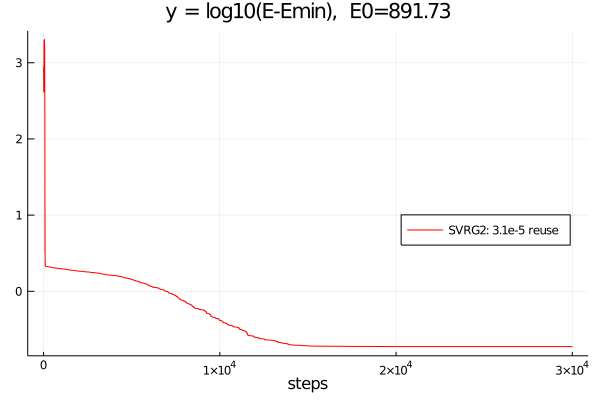

In [341]:
# γ = (Lo+2*m*Li)/(m*L)
# println("γ = ",γ)
fig3 = plot(legend=:right,title="y = log10(E-Emin),  E0=$(round(E0,digits=2))",xlabel="steps")
# plot!(log10.(eng3),label="SGD: $(η_SGD)",color=:green)
# plot!(fig3,γ*collect(1:length(eng4)),log10.(eng4),label="SVRG1: $η",color=:blue)
plot!(fig3,1:length(eng5),log10.(eng5),label="SVRG2: $η reuse",color=:red)# name is not true
println("i = ",i)
# plot(eng3)
# savefig(fig3,"SVRGexTest$i.svg")
fig3

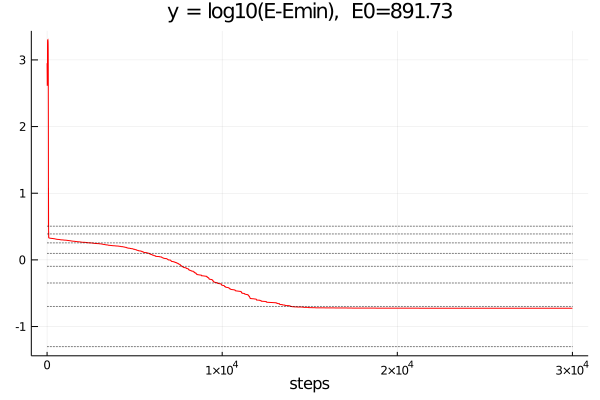

In [344]:
fig4 = deepcopy(fig3)
for i in 2:min(9,size(H,1))
    plot!(fig4,[0,length(eng5)],log10(H[i,i])*ones(2),legend=false,color=:black,linestyle=:dot)
end
fig3 = fig4

saved to SVRGtest8_localMinimal2_d=2000.pdf


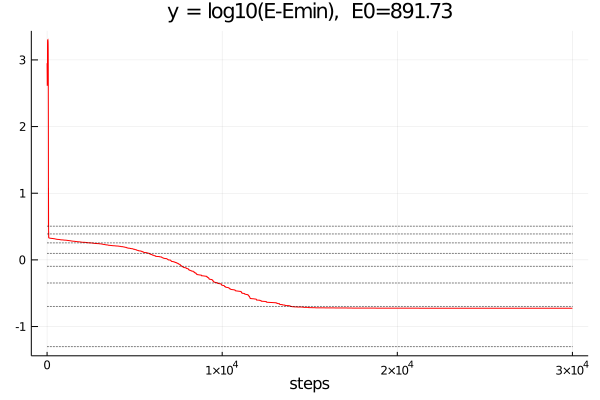

In [345]:
i = 8
filename = "SVRGtest$(i)_localMinimal2_d=2000.pdf"
savefig(fig3,filename)
println("saved to ",filename)
fig3

In [ ]:
H = Diagonal(map(x->x^2/20.0,collect(0:10)))
ψ0 = normalize(collect(1:size(H,1)))
_, eng1 = mkNormalSGD(ψ0,H,4000,50,0.004)
_, eng2 = tgNormalSGD(ψ0,H,4000,0.004)
# _, eng3 = mkReweightSVRG(ψ0,H,outer=200,inner=20,long=400,short=50,η=0.005)

figeng = plot(log10.(eng1),label="SGD")
fig1 = plot!(figeng,log10.(eng2),label="GD",title="log(E-E0)")
# plot(eng2)
savefig("gd-sgd.svg")
fig1

In [ ]:
plot(eng,color=:red)